In [19]:
import argparse
import pandas as pd
import os
import json
import torch
import sys

#current_dir = os.getcwd()
#print("Current Working Directory:", current_dir)

#sys.path.append(f'{("/").join(current_dir.rsplit("/")[0:6])}/utils')
#print(sys.path)

from utils.Utils import generate_data, scale_inputs_real_knockout_explainability, evaluate_model, get_significant_samples
from utils.Plots import plot_boxplot_with_annotations
from utils.Config import Config
from modelsNN.modelsNN import DeepRBP
from calculate_deeplift_values import perform_deeplift_pipeline

# Tutorial 1 : DeepRBP on real knockdown data using a trained model with TCGA  
In this tutorial, we will show you an example of the application of DeepRBP in the GSE136366 experiment where the RBP TARDBP (TDP43) was knocked out. Here, the code to perform the following steps is provided:

1) Process raw samples to generate the input data for DeepRBP (obtained in *Tutorial_0* is created that contains the necessary inputs to run the DeepRBP model for both control and knockout samples (RBP and gene expression matrices, as well as those of the transcripts).
2) Pass the control data through the predictive model trained on TCGA and make predictions and calculate Pearson correlation, Spearman, and MSE.
3) Pass the data through the explainability module and calculate the RBPxTranscripts and RBPxGenes matrices.
4) Some plots.

## 0. Define the local variables

In [20]:
path_exp = './tutorial_1/experiments/GSE136366'  # Path to real kd data of this experiment (raw data JUAN)
path_data = '../data' # Path to data folder
experiment = path_exp.rsplit('/')[-1] # Name of the experiment
rbp_interest = 'TARDBP' # Knocked RBP in this experiment
path_model = './model'  # Path to trained model with TCGA
path_result = './tutorial_1/results'  # Results folder

In [44]:
getBM = pd.read_csv('../data/extra/getBM_reduced.csv', index_col=0)  # getBM thar relates transcript names to its gene
getBM = getBM.sort_values(by='Transcript_ID').reset_index(drop=True)
getBM.head()
getBM.shape

(11462, 5)

In [28]:
# Define the two experiment conditions
condition1 = experiment+'_control'
condition2 = f'{experiment}_{rbp_interest}_kd'
print(condition1)
print(condition2)

GSE136366_control
GSE136366_TARDBP_kd


## 1. Process raw samples to generate the input data for DeepRBP

First of all, you can download the samples from this experiment using the script and tutorial if you haven't done so yet. Next, we will show the description of the samples and generate the necessary data to fit to DeepRBP.

As you can see by running the following line of code, this experiment contains 6 samples, 3 knockouts identified as tdp43_ko in the 'sample_title' column, and 3 controls ('Rescued_tdp43'). In the 'run_accession' column, you can read the sample name (for example SRR10045016), and if you go to the folder with the same name in path_data, you will find the data containing abundance and expression data in TPM.

Furthermore, in the limma folder, you have a table with results from the differential expression analysis between control and knockout data. In this case, we provide this table, but you can reproduce the results using the script limma_analysis_real_kds.R and the *processed_abundance* files created after processing the raw data.

In [29]:
description = pd.read_csv(path_exp+f'/info_samples.txt', delimiter='\t')
print(description)

  run_accession   sample_title
0   SRR10045016       tdp43_ko
1   SRR10045017       tdp43_ko
2   SRR10045018       tdp43_ko
3   SRR10045019  Rescued_tdp43
4   SRR10045020  Rescued_tdp43
5   SRR10045021  Rescued_tdp43


Using the description of the samples the id samples belonging to normal and knockout are identified. In the next step control and knockout samples are treated independently. 
Giving a condition for each sample the transcript tpm, counts and genes tpm vectors are created. Samples of the same condition are merged in the same matrix. Then this data is processed to be able to fit DeepRBP model as explained in home readme.md.

The files created for example for control conditon are:
./experiments/GSE136366/datasets

- control_gn_expr_iso_tpm.csv
- control_RBPs_log2p_tpm.csv
- control_trans_est_counts.csv
- control_trans_log2p_tpm.csv 

In [30]:
# Generate data from raw samples
generate_data(description, condition1, condition2, path_exp, path_data)

[utils] Generating the data ...
[identify_samples_from_tissue] The condition selected is GSE136366_control
[identify_samples_from_tissue] The samples related to this condition are: ['SRR10045019', 'SRR10045020', 'SRR10045021']
[identify_samples_from_tissue] The condition selected is GSE136366_TARDBP_kd
[identify_samples_from_tissue] The samples related to this condition are: ['SRR10045016', 'SRR10045017', 'SRR10045018']
[utils] Identify the samples for this tissue ... -> DONE
[process_and_save_expression_data] 1. Merging the samples ... 
[process_and_save_expression_data] We are processing the sample: SRR10045019 from tissue: GSE136366_control
[create_vec_exp_matrix_from_abundance] Read the abundance.tsv file of sample: SRR10045019 ... -> DONE
[create_vec_exp_matrix_from_abundance] Expand detailed information from target_id column and reorder columns ... -> DONE
[create_vec_exp_matrix_from_abundance] Remove version name from Transcript_ID and Gene_ID ... -> DONE
[create_vec_exp_matrix_

In [31]:
data_control = scale_inputs_real_knockout_explainability(path_model, f'{path_exp}/datasets', condition=condition1)
data_kd = scale_inputs_real_knockout_explainability(path_model, f'{path_exp}/datasets', condition=condition2)

df_rbps_control = data_control.df_scaled_rbps
df_labels_control = data_control.df_labels
df_gns_control = data_control.df_gns
df_rbps_kd = data_kd.df_scaled_rbps
df_labels_kd = data_kd.df_labels
df_gns_kd = data_kd.df_gns

[utils] Prepare inputs real knockout explainability ...
[utils] Load Data & Sort columns ... -> DONE 

[utils][get_scaled_rbp_test_data] Scale test data with the scaler used in Training ... -> DONE 
[utils] Scale Data: Load the scaler and sigma used in the SF data in the model training and scale 

[utils] Prepare inputs real knockout explainability ...
[utils] Load Data & Sort columns ... -> DONE 

[utils][get_scaled_rbp_test_data] Scale test data with the scaler used in Training ... -> DONE 
[utils] Scale Data: Load the scaler and sigma used in the SF data in the model training and scale 



## 2) Pass the control data through the predictive model trained on TCGA and make predictions and Calculate Pearson correlation, Spearman, and MSE.

In [32]:
print(df_rbps_control.head())
print(df_labels_control.head())
print(df_gns_control.head())

                 A1CF      AATF  ABCF1      ABT1     ACAA2     ACIN1  \
SRR10045019  0.403775  0.835535    1.0  0.892151  0.628175  0.845815   
SRR10045020  0.424557  0.777661    1.0  0.864083  0.625216  0.816824   
SRR10045021  0.418073  0.802718    1.0  0.884037  0.627027  0.816188   

                 ACTB     ACTN1     ACTN4      ADAR  ...    ZNF598  ZNF622  \
SRR10045019  0.559281  0.488222  0.691345  0.727529  ...  0.986533     1.0   
SRR10045020  0.539138  0.483268  0.691942  0.707206  ...  0.949694     1.0   
SRR10045021  0.568359  0.484934  0.717111  0.732928  ...  0.974424     1.0   

               ZNF638    ZNF768     ZNFX1  ZNHIT6  ZRANB2     ZRSR1     ZRSR2  \
SRR10045019  0.516139  0.424464  0.464874     1.0     1.0  0.640470  0.701813   
SRR10045020  0.465582  0.400175  0.444102     1.0     1.0  0.620408  0.654460   
SRR10045021  0.494754  0.441206  0.448134     1.0     1.0  0.447433  0.723331   

                  ZYX  
SRR10045019  0.526551  
SRR10045020  0.546010  
S

In [33]:
# Psarlos por el predictive model entrenado en TCGA y sacar las predicciones
# Load the model with the trained parameters with TCGA
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
with open(f'{path_model}/config.json', 'r') as file:
    config_dict = json.load(file)
config_obj = Config(**config_dict)
model = DeepRBP(n_inputs=df_rbps_control.shape[1], n_outputs=df_labels_control.shape[1], config=config_obj, device=device)
model.load_state_dict(torch.load(path_model+'/model.pt', map_location=device))      
model.eval()

You are using a model with 2 hidden layers


DeepRBP(
  (linear0): Linear(in_features=1282, out_features=1024, bias=True)
  (bn0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a_function0): ReLU()
  (linear1): Linear(in_features=1024, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a_function1): ReLU()
  (final_layer): Linear(in_features=128, out_features=11462, bias=True)
)

In [34]:
# Calcular pearson correlation, spearman, y MSE
evaluate_model(model, df_rbps_control, df_gns_control, df_labels_control, df_rbps_kd, df_gns_kd, df_labels_kd, device, condition1, condition2)

[utils] Results in all GSE136366_control data -> spear cor: 0.817, pear_cor: 0.911 & mse: 0.418
[utils] Results in all GSE136366_TARDBP_kd data -> spear cor: 0.811, pear_cor: 0.912 & mse: 0.411


## 3) Pass the data through the explainability module and calculate the RBPxTranscripts and RBPxGenes matrices.

In [35]:
df_deeplift_scores_TxRBP, df_deeplift_scores_GxRBP = perform_deeplift_pipeline(
                                                        df_scaled_test = df_rbps_control, 
                                                        test_labels = df_labels_control, 
                                                        test_gn = df_gns_control, 
                                                        model = model, 
                                                        path_save = path_save, 
                                                        getBM = getBM, 
                                                        select_reference='knockout', 
                                                        method='tstat'
                                                        )

[calculate_rbp_reference] You selected the knockout RBP expression as reference
reference of the RBP expression: tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
[calculate_rbp_reference] Calculate the reference of the RBP expression data: knockout of the test data ... -> DONE
[perform_deeplift_pipeline] Calculate the reference of the RBP expression data ... -> DONE
[perform_deeplift_pipeline] reference of the RBP expression: tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
[perform_deeplift_pipeline] Calculate shapley scores with DeepLIFT
[create_deeplift_scores_dataframe] DeepLIFT in the output layer nodes


Calculating scores:   0%|                           | 0/11462 [00:00<?, ?node/s]/opt/anaconda3/envs/DeepRBP/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
Calculating scores: 100%|███████████████| 11462/11462 [03:55<00:00, 48.65node/s]


[create_deeplift_scores_dataframe] Calculate deeplift scores for all nodes ... -> DONE
[perform_deeplift_pipeline] Calculate shapley scores with DeepLIFT ... -> DONE
[reduce_batch_dimension] The reduce method selected is tstat


Calculating t-stat: 100%|██████████| 11462/11462 [07:52<00:00, 24.28rbp index/s]


[perform_deeplift_pipeline] Reduce batch dimension ... -> DONE
[perform_deeplift_pipeline] Set low-expressed genes (mean < 1TPM) to 1 of the TxRBP to 0 ... -> DONE
[perform_deeplift_pipeline] Saved df_DeepLIFT_TxRBPs.csv in ./tutorial_1/results/GSE136366
[get_deeplift_scores_genes] Group values by gene - take the max absolute value of the transcripts per gene ... -> DONE
[perform_deeplift_pipeline] Saved df_DeepLIFT_GxRBPs.csv in ./tutorial_1/results/GSE136366


In [38]:
print(df_deeplift_scores_TxRBP)
print(df_deeplift_scores_GxRBP)

                      A1CF       AATF      ABCF1       ABT1       ACAA2  \
ENST00000006015   2.615540   4.157407  -1.259095  20.904881   21.851439   
ENST00000006750   0.000000   0.000000   0.000000   0.000000    0.000000   
ENST00000009530   0.000000   0.000000   0.000000   0.000000    0.000000   
ENST00000027335   0.000000   0.000000   0.000000   0.000000    0.000000   
ENST00000034275 -21.821203 -44.534863  15.779265 -53.615150 -181.193314   
...                    ...        ...        ...        ...         ...   
ENST00000632133  12.672439   3.284807  -9.177382  33.787315  -82.530884   
ENST00000632375  12.613299 -19.572962 -12.136581  17.741060    3.890284   
ENST00000633063  18.275227  -4.351339  27.562927  31.783472   -4.174599   
ENST00000633317 -22.180025   3.039302 -25.543005 -17.556887   17.356480   
ENST00000633691   4.420446   1.494147  12.607919   6.587122  -13.246799   

                     ACIN1       ACTB       ACTN1      ACTN4         ADAR  \
ENST00000006015  11.23

## 4) Plot the results

There is a Limma result dataframe saved in your directory
./tutorial_1/experiments/GSE136366/limma/limma_GSE136366_TARDBP_results.csv
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TARDBP_Yes vs. TARDBP_No: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.308e-07 U_stat=1.310e+06


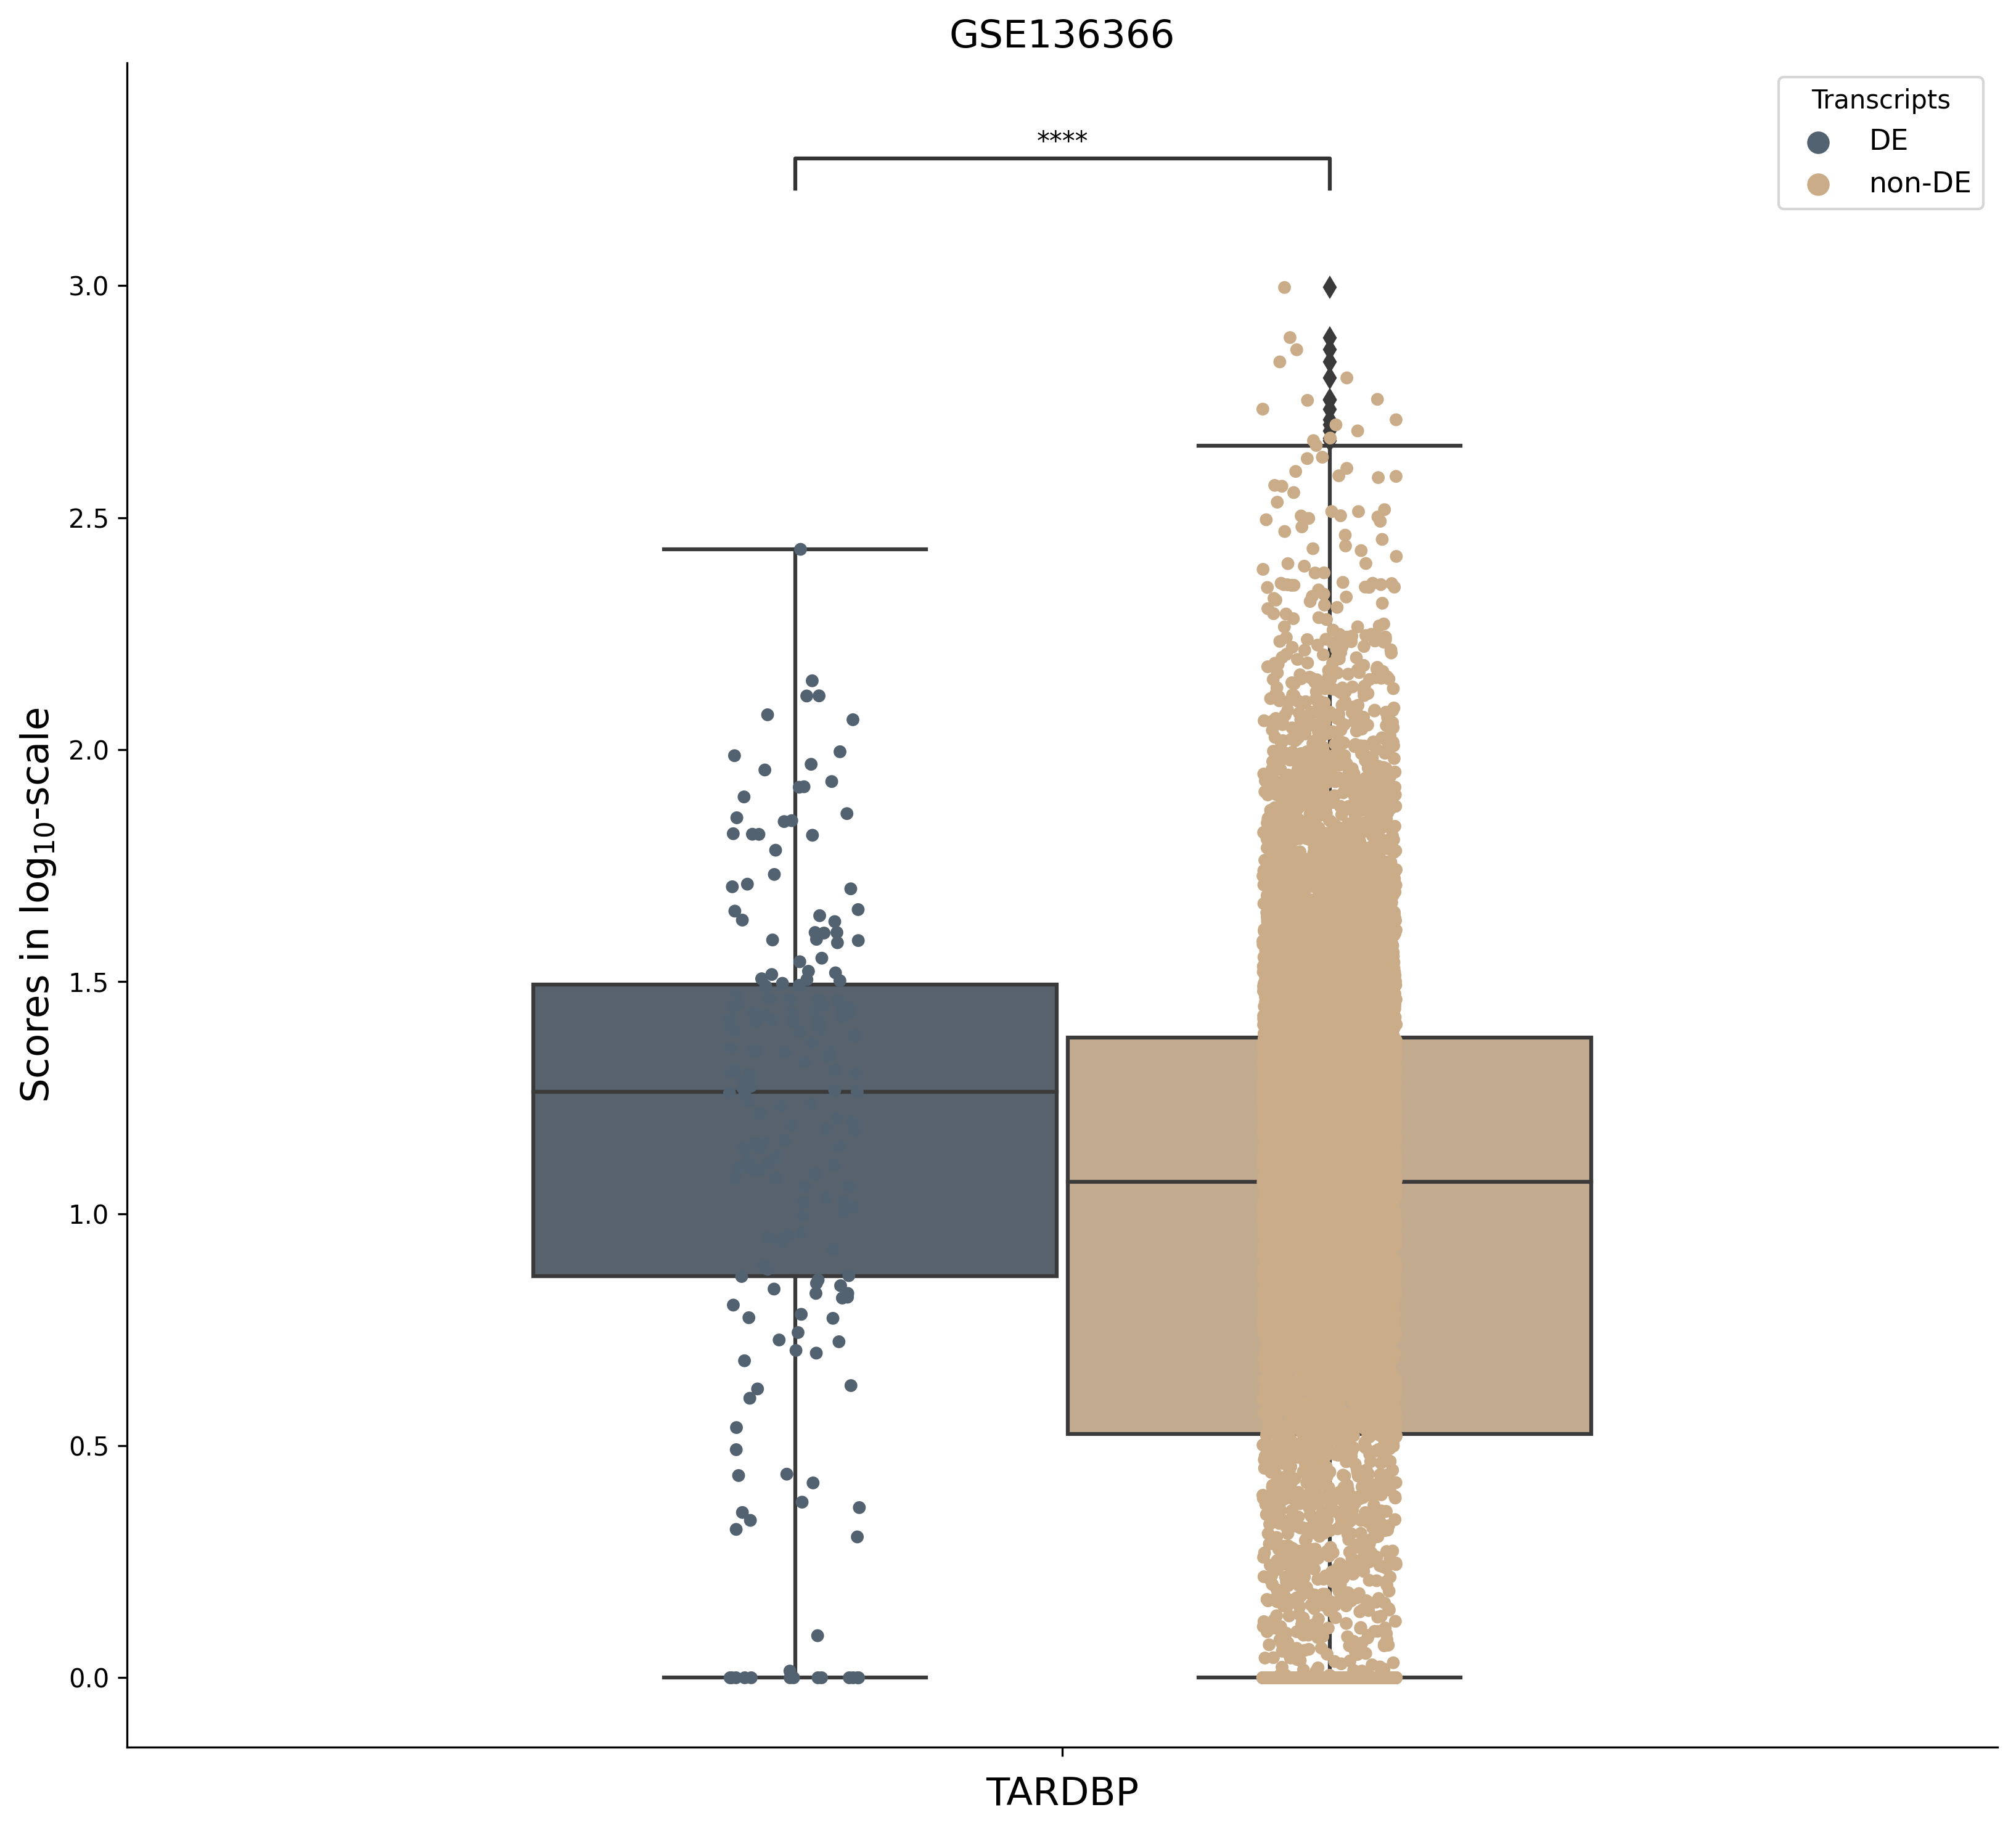

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TARDBP_Yes vs. TARDBP_No: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.907e-09 U_stat=8.998e+04


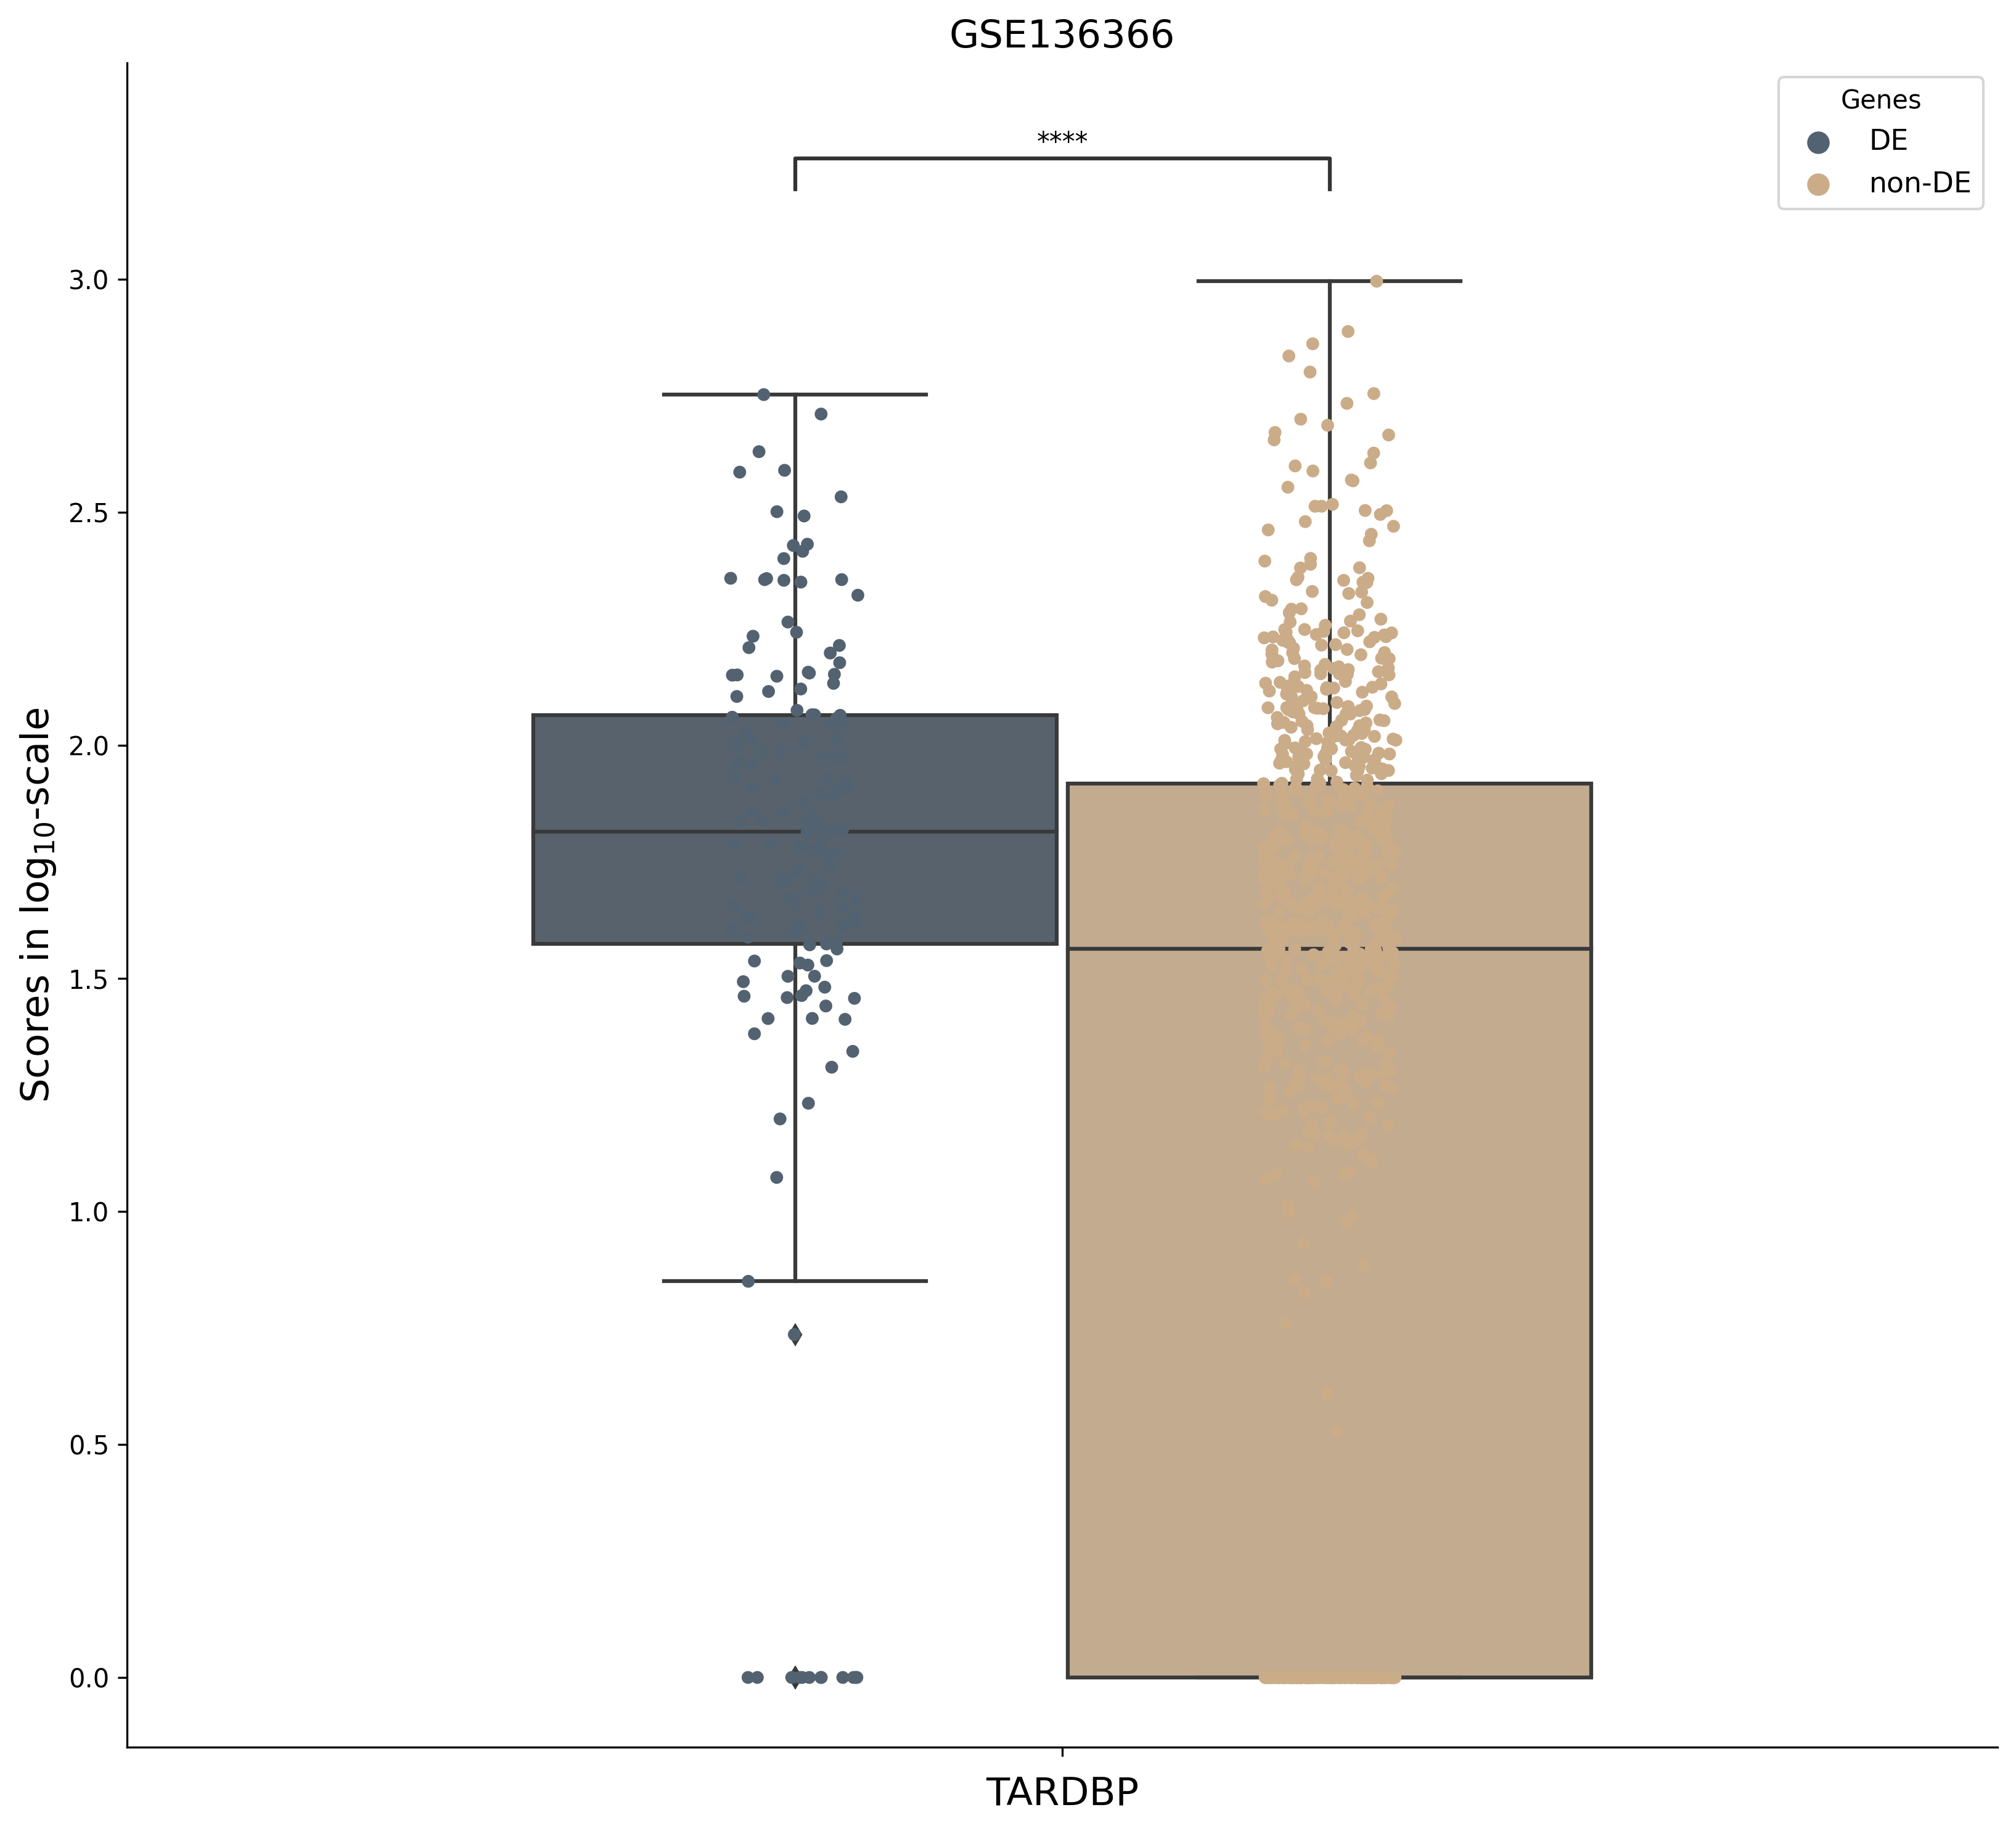

In [43]:
# Plots using the scores agains DE-transcripts and DE-genes
path_save = path_result+f'/{experiment}'
significant_samples, significant_samples_gns = get_significant_samples(rbp_interest, experiment, path_exp, df_deeplift_scores_TxRBP)   
plot_boxplot_with_annotations(df=df_deeplift_scores_TxRBP, significant_samples=significant_samples, rbp_interest=rbp_interest, experiment=experiment, path_save=path_save, data_type='Transcripts')
plot_boxplot_with_annotations(df=df_deeplift_scores_GxRBP, significant_samples=significant_samples_gns, rbp_interest=rbp_interest, experiment=experiment, path_save=path_save, data_type='Genes')